### Imports

In [1]:
import heeps
from heeps.util.save2fits import save2fits
from heeps.util.img_processing import crop_cube
from heeps.contrast.background import background
import vip_hci
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import ScalarFormatter
from astropy.io import fits
import os.path
import warnings

### End-to-end Propogation

In [2]:
# 1. Create a config dictionary
conf = dict(
    band = 'L',
    mode = 'CVC',
    file_pupil = 'pupil/ELT_fullM1.fits',
    file_phase = 'wavefront/cube_Cbasic_20201130_3600s_300ms_0piston_meters_scao_only_285.fits',
    file_lyot_stop = '',
    add_phase = True,
    add_amp = False,
    add_bckg=True,
    dir_output = 'post_processing/scao_only',
    cpu_count = None,
    nframes = 12000,
    nstep = 6,
)
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf)
conf['ls_dRext'] = 0.0291
conf['ls_dRint'] = 0.08
conf['ls_dRspi'] = 0.0317
dir_output = conf['dir_output']
ndet = conf['ndet']
nframes = conf['nframes']
nstep = conf['nstep']
nscreens = int((nframes/nstep) + 0.5)
cube_duration = conf['cube_duration']
lam = conf['lam']
pscale = conf['pscale']
mode = conf['mode']
band = conf['band']

# 2. Load entrance pupil, and create 'wavefront' object
wf = heeps.pupil.pupil(savefits=True, verbose=True, **conf)

# 3. Load wavefront errors
phase_screens, amp_screens, tiptilts, misaligns = heeps.wavefront.load_errors(verbose=True, **conf)

# 4. Propagate one frame of offaxis psf (i.e. planet)
psf = heeps.wavefront.propagate_one(wf, onaxis=False, savefits=True, verbose=True, **conf)

# 5. Propagate cube of onaxis psfs (i.e. star)
psfs = heeps.wavefront.propagate_cube(wf, phase_screens=phase_screens, \
    amp_screens=amp_screens, tiptilts=tiptilts, misaligns=misaligns, onaxis=True, \
    savefits=True, verbose=True, **conf)

Simulation config: band=L, mode=CVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, beam_ratio=0.2568
   npupil=285, pscale=5.47 mas, lam=3.8112E-06 m
   hfov=1.1 arcsec (-> ndet=403, 51.74 lam/D)



### Input parameters

In [3]:
mag=5         # star magnitude
lat=-24.59    # telescope latitude in deg
dec=-5        # star declination in deg
starphot=1e11 # normalization factor for aperture photometry

### Load PSFs and add background

In [4]:
# PSF filenames
loadname = os.path.join(dir_output, '%s_PSF_%s_%s.fits'%('%s', band, mode))
# get normalized on-axis PSFs (star)
psf_ON = fits.getdata(loadname%'onaxis')
assert psf_ON.ndim == 3, "on-axis PSF cube must be 3-dimensional"
# cut/crop cube
if nscreens != None:
    psf_ON = psf_ON[:nscreens]
if ndet != None:
    psf_ON = crop_cube(psf_ON, ndet)
# get normalized off-axis PSF (planet)
psf_OFF = fits.getdata(loadname%'offaxis')
if psf_OFF.ndim == 3:
    psf_OFF = psf_OFF[0,:,:] # only first frame
print('Load PSFs for ADI')
print('   mode=%s, band=%s, pscale=%s'%(mode, band, pscale))
print('   cube_duration=%s, ncube=%s, ndet=%s'%(cube_duration, psf_ON.shape[0], psf_ON.shape[1]))
# add background and photon noise: include star flux and HCI mode transmission
if conf['add_bckg'] is True:
    conf.update(mode=conf['mode'], cube_duration=conf['cube_duration'], mag=conf['mag'])
    psf_ON, psf_OFF = background(psf_ON, psf_OFF, verbose=True, **conf)
# apply APP Strehl
if 'APP' in conf['mode']:
    psf_OFF *= conf['app_strehl']


Load PSFs for ADI
   mode=CVC, band=L, pscale=5.47
   cube_duration=3600, ncube=2000, ndet=403
   offaxis_trans=0.7286, mask_trans=0.8532,
   mag=5, DIT=1.800
   star_signal=1.62E+09, bckg_noise=9.93E+04


#### Aperture photometry of psf_OFF used to scale the contrast 

In [5]:
# get the center pixel
(xoff, yoff) = psf_OFF.shape
(cx, cy) = (int(xoff/2), int(yoff/2))
# fit a 2D Gaussian --> output: fwhm, x-y centroid
rim = 19 #psf image radius in pixels
fit = vip_hci.var.fit_2dgaussian(psf_OFF[cx-rim:cx+rim+1, \
        cy-rim:cy+rim+1], True, (rim,rim), debug=False, full_output=True)
# derive the FWHM
fwhm = np.mean([fit['fwhm_x'],fit['fwhm_y']])
# recenter and crop
shiftx, shifty = rim-fit['centroid_x'], rim-fit['centroid_y']
psf_OFF = vip_hci.preproc.frame_shift(psf_OFF, shiftx, shifty)
psf_OFF_crop = psf_OFF[cx-rim:cx+rim+1, cy-rim:cy+rim+1]
# FWHM aperture photometry of psf_OFF_crop
ap_flux = vip_hci.metrics.aperture_flux(psf_OFF_crop, [rim], [rim], \
        fwhm, verbose=False)[0]
# normalize to starphot (for VIP)
if starphot is None:
    starphot = ap_flux
else:
    psf_ON *= starphot/ap_flux
    psf_OFF_crop *= starphot/ap_flux

#### Parallactic angles for ADI

In [6]:
ha = cube_duration/3600/24*360
# angles in rad
hr = np.deg2rad(np.linspace(-ha/2, ha/2, psf_ON.shape[0]))
dr = np.deg2rad(dec)
lr = np.deg2rad(lat)
# parallactic angle in deg
pa = -np.rad2deg(np.arctan2(-np.sin(hr), np.cos(dr)*np.tan(lr) \
        - np.sin(dr)*np.cos(hr)))

### Post-processing 

### ADI

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2021-05-09 21:21:42
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : median_sub, FWHM = 3.5276150457498976, # BRANCHES = 1, SIGMA = 5, STARPHOT = 100000000000.0
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Finished the throughput calculation
Running time:  0:19:05.045226
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


(1e-08, 0.01)

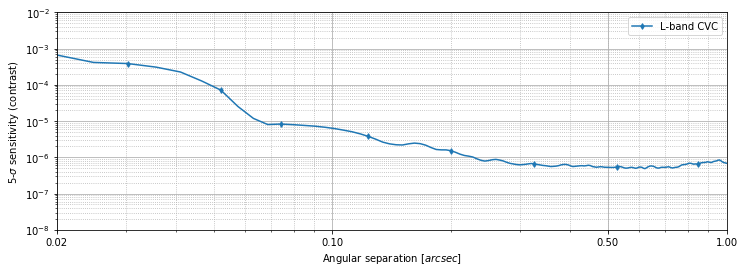

In [7]:
# contrast curve after post-processing (pscale in arcsec)
with warnings.catch_warnings():
    warnings.simplefilter("ignore") # for AstropyDeprecationWarning
    cc_pp = vip_hci.metrics.contrast_curve(psf_ON, pa, psf_OFF_crop, \
            fwhm, pscale/1e3, starphot, algo=vip_hci.medsub.median_sub, nbranch=1, sigma=5, \
            debug=False, plot=False, verbose=True)
# angular separations (in arcsec)
sep = cc_pp.loc[:,'distance_arcsec'].values
# sensitivities (Student's or Gaussian distribution)
distrib = 'sensitivity_student' if conf['student_distrib'] == True else 'sensitivity_gaussian'
sen = cc_pp.loc[:,distrib].values
# filename for fitsfiles
if conf['add_bckg'] is True:
    name = 'adi_bckg%s_mag%s'%(int(conf['add_bckg']), mag)
else:
    name = 'adi_bckg%s'%int(conf['add_bckg'])
# tag
tag = 'ADI'
# save contrast curves as fits file
save2fits(np.array([sep,sen]), 'cc_%s%s%s'%(name, '_%s_%s', tag), dir_output=dir_output, band=band, mode=mode)
# psf after post-processing
_, _, psf_pp_adi = vip_hci.medsub.median_sub(psf_ON, pa, full_output=True, verbose=False)
save2fits(psf_pp_adi, 'psf_%s%s%s'%(name, '_%s_%s', tag), dir_output=dir_output, band=band, mode=mode)
# plot contrast curve
plt.figure(figsize=(12,4))
plt.grid(True), plt.grid(which='minor', linestyle=':')
plt.loglog(), plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.xlabel('Angular separation $[arcsec]$')
plt.ylabel('5-$\sigma$ sensitivity (contrast)')
label = '%s-band %s'%(conf['band'], conf['mode'])
plt.plot(sep, sen, label=label, marker='d', markevery=0.12, markersize=4)
plt.legend()
plt.xticks([0.02, 0.1, 0.5, 1])
plt.xlim(0.02,1)
plt.ylim(1e-8,1e-2)

### PCA

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2021-05-10 08:19:19
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 270.376 GB
System available memory = 170.087 GB
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:01:32.586456
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


/mnt/diskss/home/mshinde/miniconda3/lib/python3.7/site-packages/vip_hci/pca/utils_pca.py:240: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  yy, xx = draw.circle(y, x, fwhm / 2.)


Number of steps 50
Optimal number of PCs = 8, for S/N=-0.142
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Coords of chosen px (X,Y) = 220.0, 220.0
Flux in a centered 1xFWHM circular aperture = -255785.980
Central pixel S/N = -0.286
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = -0.142
Max S/N (shifting the aperture center) = 0.103
stddev S/N (shifting the aperture center) = 0.156



/mnt/diskss/home/mshinde/miniconda3/lib/python3.7/site-packages/vip_hci/metrics/snr_source.py:411: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  yy, xx = draw.circle(y, x, fwhm / 2)


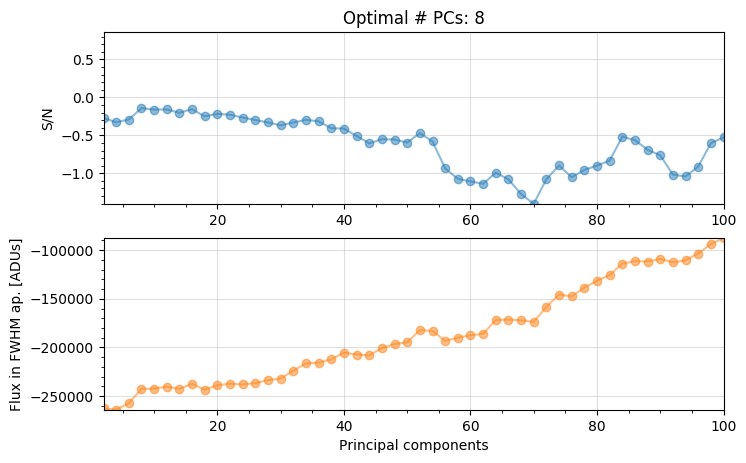

In [7]:
pca_arr = vip_hci.pca.pca(psf_ON, pa, ncomp=(2, 101, 2), full_output=True, \
       source_xy=(220, 220), fwhm=fwhm, verbose=True)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2021-05-10 10:06:23
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 3.5276150457498976, # BRANCHES = 1, SIGMA = 5, STARPHOT = 100000000000.0
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Finished the throughput calculation
Running time:  0:22:47.343025
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
No. of PCs = 8


(1e-08, 0.01)

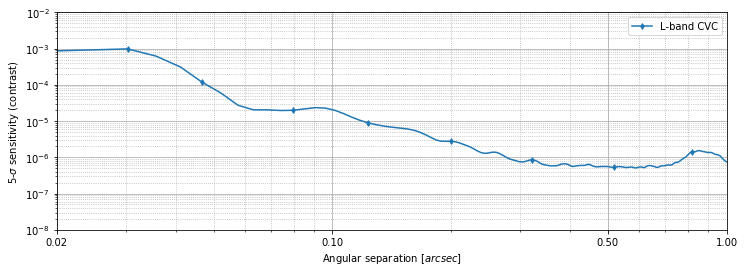

In [10]:
ncomp = 8
# contrast curve after post-processing (pscale in arcsec)
with warnings.catch_warnings():
    warnings.simplefilter("ignore") # for AstropyDeprecationWarning
    cc_pp = vip_hci.metrics.contrast_curve(psf_ON, pa, psf_OFF_crop, \
            fwhm, pscale/1e3, starphot, algo=vip_hci.pca.pca, nbranch=1, sigma=5, \
            debug=False, plot=False, verbose=True, ncomp=ncomp)
# angular separations (in arcsec)
sep = cc_pp.loc[:,'distance_arcsec'].values
# sensitivities (Student's or Gaussian distribution)
distrib = 'sensitivity_student' if conf['student_distrib'] == True else 'sensitivity_gaussian'
sen = cc_pp.loc[:,distrib].values
# filename for fitsfiles
if conf['add_bckg'] is True:
    name = 'adi_bckg%s_mag%s'%(int(conf['add_bckg']), mag)
else:
    name = 'adi_bckg%s'%int(conf['add_bckg'])
# tag
tag = 'ADI-PCA_ncomp%s'%ncomp
# save contrast curves as fits file
save2fits(np.array([sep,sen]), 'cc_%s%s%s'%(name, '_%s_%s', tag), dir_output=dir_output, band=band, mode=mode)
# psf after post-processing
psf_pp, pcs, _, _, _ = vip_hci.pca.pca(psf_ON, pa, full_output=True, verbose=False, ncomp=ncomp)
save2fits(psf_pp, 'psf_%s%s%s'%(name, '_%s_%s', tag), dir_output=dir_output, band=band, mode=mode)
print('No. of PCs =', pcs.shape[0])
# plot contrast curve
plt.figure(figsize=(12,4))
plt.grid(True), plt.grid(which='minor', linestyle=':')
plt.loglog(), plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.xlabel('Angular separation $[arcsec]$')
plt.ylabel('5-$\sigma$ sensitivity (contrast)')
label = '%s-band %s'%(conf['band'], conf['mode'])
plt.plot(sep, sen, label=label, marker='d', markevery=0.12, markersize=4)
plt.legend()
plt.xticks([0.02, 0.1, 0.5, 1])
plt.xlim(0.02,1)
plt.ylim(1e-8,1e-2)

/mnt/diskss/home/mshinde/miniconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


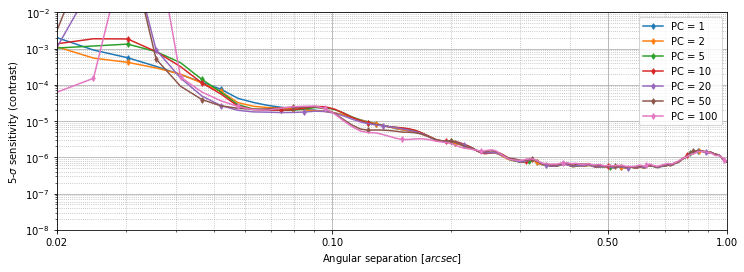

In [8]:
plt.figure(figsize=(12,4))
plt.grid(True), plt.grid(which='minor', linestyle=':')
plt.loglog(), plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.xlabel('Angular separation $[arcsec]$')
plt.ylabel('5-$\sigma$ sensitivity (contrast)')
ax = plt.subplot()

for ncomp in [1,2,5,10,20,50,100]:
    # contrast curve after post-processing (pscale in arcsec)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore") # for AstropyDeprecationWarning
        cc_pp = vip_hci.metrics.contrast_curve(psf_ON, pa, psf_OFF_crop, \
                fwhm, pscale/1e3, starphot, algo=vip_hci.pca.pca, nbranch=1, sigma=5, \
                debug=False, plot=False, verbose=False, ncomp=int(ncomp))
    # angular separations (in arcsec)
    sep = cc_pp.loc[:,'distance_arcsec'].values
    # sensitivities (Student's or Gaussian distribution)
    distrib = 'sensitivity_student' if conf['student_distrib'] == True else 'sensitivity_gaussian'
    sen = cc_pp.loc[:,distrib].values
    # filename for fitsfiles
    if conf['add_bckg'] is True:
        name = 'adi_bckg%s_mag%s'%(int(conf['add_bckg']), mag)
    else:
        name = 'adi_bckg%s'%int(conf['add_bckg'])
    # tag
    tag = 'ADI-PCA_ncomp%s'%ncomp
    # save contrast curves as fits file
    save2fits(np.array([sep,sen]), 'cc_%s%s%s'%(name, '_%s_%s', tag), dir_output=dir_output, band=band, mode=mode)
    # plot contrast curve
    plt.plot(sep, sen, label='PC = %s'%ncomp , marker='d', markevery=0.12, markersize=4)
    
plt.xticks([0.02, 0.1, 0.5, 1])
plt.xlim(0.02,1)
plt.ylim(1e-8,1e-2)
plt.legend()
plt.show()

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2021-05-10 10:04:00
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 270.376 GB
System available memory = 169.929 GB
Done vectorizing the frames. Matrix shape: (2000, 162409)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:01:34.866978
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:02:01.347555
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


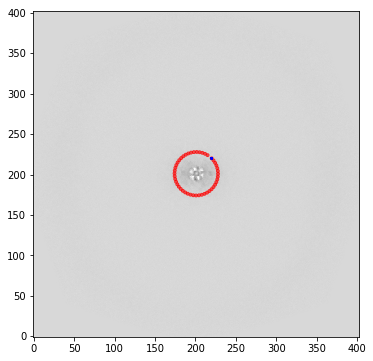

-0.28587447808048655

In [9]:
vip_hci.metrics.snr(vip_hci.pca.pca(psf_ON, pa, ncomp=8, verbose=True),
                source_xy=(220, 220), fwhm=fwhm, plot=True)